In [ ]:
!gdown --id "1eyjNIRnKVyQAg8-f3rWXXKr_eXQHFbMl"

In [ ]:
pip install hazm

In [5]:
import pandas as pd
import numpy as np
import csv

from sklearn import preprocessing
from __future__ import unicode_literals
from hazm import *
import time
import string 
from functools import reduce
import operator

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

import sklearn.metrics as metrics

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
large = 22; med = 14; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': small,
          'figure.figsize': (10, 5),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

In [6]:
def replaceChar(s, charList):
  for c in charList:
    s = s.replace(c, ' ')
  return normalizePersianText(s)

def normalizePersianText(s):
  return s.replace(chr(1609), chr(1740)).replace(chr(1610), chr(1740))

persianStopWords = ['از', 'به', 'با', 'است', 'میکنم', 'یه', 
        'یک', 'یا', 'هم', 'هست', 'هستش', 'نیست', 'نیستش',
        'که', 'چون', 'می‌باشد', 'میباشد', 'باشد', 'نداره', 'داره', 'ندارم'
        'دارم', 'میدم', 'می‌دهم', 'داده', 'نداده', 'می', 'دهم', 'باشد',
        'گرفتم', 'گزاشتم', 'گذاشتم', 'کنید', 'بکنید', 'کنم', 'بکنم', 'بکند',
        'کنه', 'بکنه', 'میکنه', 'میکند', 'گرفته','گرفتم', 
        'گذاشته', 'گزاشته', 'گذاشتن', 'گزاشتن']

def flatten(l, dim):
  if (dim == 2):
    return reduce(operator.concat, l)
  return reduce(operator.concat, flatten(l, dim - 1))

RANDOMSTATE = 287
pd.options.mode.chained_assignment = None

In [57]:
class Model:
  def __init__(self, df, targetName, maxFeatures = 100):
    self.df = df
    self.df.columns = ['index'] + list(self.df.columns)[1:]
    self.df.index = self.df['index'].values
    self.models = {}
    self.prediction = {}
    self.predictionTrain = {}
    self.predictionNoDatas = {}
    self.testIndices = None
    self.trainIndices = None
    # self.informalNormalizer = InformalNormalizer()
    # self.lemmatizer = Lemmatizer()
    self.normalizer = Normalizer()
    self.vectorizer = TfidfVectorizer(min_df=5, max_features=maxFeatures, stop_words=persianStopWords)

  def preprocessTime(self, column):
    timeCol = self.features[column].apply(time.strptime, args = ["%A %H%p"])
    self.features['weekday'] = pd.Series([t.tm_wday for t in timeCol], dtype='int32').values
    self.features['hour'] = pd.Series([t.tm_hour for t in timeCol], dtype='int32').values
    self.features = self.features.drop(column, 1)

  def oneHotEncoding(self, featureName):
    dfOneHot = pd.get_dummies(self.df[featureName])
    self.df = pd.concat([self.df, dfOneHot], axis=1).drop(featureName, axis=1)

  def normalizeText(self, s):
    s = flatten(self.informalNormalizer.normalize(self.normalizer.character_refinement(s))[0], 2)
    return ' '.join(map(str, s))

  def preprocessText(self, column):
    self.df[column] = self.df[column].apply(
        replaceChar, args = [string.punctuation]).apply(self.normalizer.normalize).values

  def preprocess(self):
    # self.preprocessText('desc')
    # self.preprocessText('title')
    self.df['text'] = self.df['title'].str.cat(self.df['desc'], sep = ' ')
    self.preprocessText('text')
    self.df = self.df.drop('title', axis=1)
    self.df = self.df.drop('desc', axis=1)
    self.df = self.df.drop('image_count', axis=1)
    # le = preprocessing.LabelEncoder()
    # self.preprocessTime('created_at')
    # self.df['created_at'] = le.fit_transform(self.df['created_at'])
    # self.df['brand'] = labelEncoder.fit_transform(self.df['brand'])
    self.df = self.df.drop('created_at', axis=1)
    self.oneHotEncoding('city')
    self.oneHotEncoding('brand')
    self.toPredict = self.df[self.df['price'] == -1].copy()
    indexNames = self.df[self.df['price'] < 50000].index
    self.df.drop(indexNames , inplace=True)
    self.target = self.df['price']
    self.features = self.df.drop('price', 1)
    # scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler(feature_range=(1, 1000))
    # scaler = preprocessing.RobustScaler()
    # scaler = preprocessing.PowerTransformer()
    # self.target = scaler.fit_transform(self.target.values.reshape(
    #         self.target.shape[0], 1))

  def splitData(self, testSize = 0.2):
    indices = self.features.index
    self.featuresTrain, self.featuresTest, self.targetTrain, self.targetTest, self.trainIndices, self.testIndices = train_test_split(
        self.features, self.target, indices, test_size = testSize, random_state = RANDOMSTATE)
    
  def processText(self, column):
    bagOfWords = self.vectorizer.fit_transform(self.featuresTrain[column])
    words = self.vectorizer.get_feature_names()
    TFIDF = pd.DataFrame(list(bagOfWords.toarray()), index = self.featuresTrain.index, columns = words)
    self.featuresTrain = pd.concat([self.featuresTrain, TFIDF], axis=1).drop(column, axis=1)
    bagOfWordsTest = self.vectorizer.transform(self.featuresTest[column])
    TFIDFTest = pd.DataFrame(list(bagOfWordsTest.toarray()), index = self.featuresTest.index, columns = words)
    self.featuresTest = pd.concat([self.featuresTest, TFIDFTest], axis=1).drop(column, axis=1)

  def initModels(self):
    self.models['DTR'] = DecisionTreeRegressor(max_depth = 20, random_state = RANDOMSTATE)
    self.models['LR'] = LinearRegression()
    self.models['Ridge'] = Ridge(alpha = 1.0, random_state = RANDOMSTATE)
    self.models['RF'] = RandomForestRegressor(max_depth = 30, max_features = 0.5,
                                              n_estimators = 50)
    
  def train(self):
    self.preprocess()
    self.splitData()
    self.processText('text')
    self.initModels()
    for model in self.models:
      self.models[model].fit(self.featuresTrain, self.targetTrain)

  def predict(self, predictTrain = False, predictTest = True):
    if (not (predictTrain or predictTest)):
      bagOfWords = self.vectorizer.transform(self.toPredict['text'])
      words = self.vectorizer.get_feature_names()
      TFIDF = pd.DataFrame(list(bagOfWords.toarray()), index = self.toPredict.index, columns = words)
      self.toPredict = pd.concat([self.toPredict, TFIDF], axis=1).drop('text', axis=1)
    for model in self.models:
      if (predictTrain):
        self.predictionTrain[model] = self.models[model].predict(self.featuresTrain)
      elif (predictTest):
        self.prediction[model] = self.models[model].predict(self.featuresTest)
      else:
        self.predictionNoDatas[model] = self.models[model].predict(self.toPredict.drop('price', axis=1))

  def evaluate(self, train = False):
    if (train):
      predicted = self.predictionTrain
      real = self.targetTrain
    else:
      predicted = self.prediction
      real = self.targetTest
    return self.getMetrics(real, predicted)
  
  def getMetrics(self, real, predicted):
    results = pd.DataFrame(columns = ['Model', 'RMSE', 'R2 Score', 'MAE'])
    for model in self.models:
      rmse = np.sqrt(metrics.mean_squared_error(real, predicted[model]))
      r2 = metrics.r2_score(real, predicted[model])
      mae = metrics.mean_absolute_error(real, predicted[model])
      row = {'Model': model, 'RMSE': rmse, 'R2 Score': r2, 'MAE': mae}
      results = results.append(row, ignore_index=True, sort=False)
    return results

  def plotRealAndPrediction(self, sampleSize = 100, modelName = None):
    plt.plot(self.targetTest[:sampleSize], color = 'red', label = 'Real data')
    colors = ['brown', 'crimson', 'limegreen', 'magenta', 'teal', 'gold']
    if (modelName == None):
      for modelName in self.models:
        plt.plot(self.prediction[modelName][:sampleSize], color = colors.pop(), label = modelName + ' Prediction')
    else:
      plt.plot(self.prediction[modelName][:sampleSize], color = 'blueviolet', label = modelName + ' Prediction')
    plt.title('Prediction')
    plt.legend()
    plt.show()

  def plotScatter(self, modelName, sampleSize = 100):
    plt.scatter(self.testIndices[:sampleSize], self.prediction[modelName][:sampleSize], color='blueviolet', label='Prediction')
    plt.scatter(self.testIndices[:sampleSize], self.targetTest[:sampleSize], color='red', label='Actual')
    plt.scatter(self.trainIndices[:sampleSize], self.models[modelName].predict(self.featuresTrain)[:sampleSize], color='blueviolet')
    plt.scatter(self.trainIndices[:sampleSize], self.targetTrain[:sampleSize], color='red')
    plt.title('Prediction ' + modelName)
    plt.legend()
    plt.show()

  def plotHyperParamTuning(self, modelName, paramName, paramRange, scoringParam):
    paramResultTest = dict()
    paramResultTrain = dict()
    model = None
    for paramVal in paramRange:
      if (modelName == 'DTR'):
        model = DecisionTreeRegressor(max_depth = paramVal, random_state = RANDOMSTATE)
      if (modelName == 'RF'):
        maxDepth = 20
        nEstimators = 50
        if (paramName == 'max_depth'):
          maxDepth = paramVal
        if (paramName == 'n_estimators'):
          nEstimators = paramVal
        model = RandomForestRegressor(max_depth = maxDepth, max_features = 0.5,
                                              n_estimators = nEstimators)
      model.fit(self.featuresTrain, self.targetTrain)
      predictionTest = model.predict(self.featuresTest)
      predictionTrain = model.predict(self.featuresTrain)
      if (scoringParam == 'r2'):
        paramResultTest[paramVal] = r2_score(self.targetTest, predictionTest)
        paramResultTrain[paramVal] = r2_score(self.targetTrain, predictionTrain)
      if (scoringParam == 'rmse'):
        paramResultTest[paramVal] = np.sqrt(mean_squared_error(self.targetTest, predictionTest))
        paramResultTrain[paramVal] = np.sqrt(mean_squared_error(self.targetTrain, predictionTrain))
    plt.plot(list(paramResultTrain.keys()), list(paramResultTrain.values()), 'ro', label = 'Training Score', color = 'blueviolet')
    plt.plot(list(paramResultTest.keys()), list(paramResultTest.values()), 'ro', label = 'Test Score', color = 'red')
    plt.xlabel(paramName)
    plt.ylabel(scoringParam)
    plt.title('Hyperparameter Tuning')
    plt.legend()
    plt.show()

  def getBestParams(self, treeModel):
    if (treeModel == 'DT'):
      model = DecisionTreeRegressor(random_state = RANDOMSTATE)
    else:
      model = RandomForestRegressor(max_features = 0.5, n_estimators = 50)
    parameters = {'max_depth': np.arange(5, 30)}
    grid = GridSearchCV(model, parameters, cv=3)
    grid.fit(self.featuresTrain, self.targetTrain)
    print(grid.best_params_)

  



In [59]:
FILENAME = 'mobile_phone_dataset.csv'
df = pd.read_csv(FILENAME, delimiter = ',')

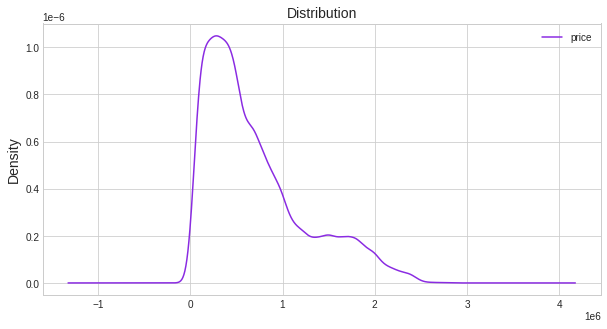

In [162]:
df['price'].plot(kind='kde', color = 'blueviolet')
plt.title('Distribution')
plt.legend()
plt.show()

In [48]:
# without scaling
model = Model(df, 'price', 1000)
model.train()
model.predict()
model.evaluate()

,Model,RMSE,R2 Score,MAE
0,DTR,323036.450054,0.657428,220347.815742
1,LR,294940.901027,0.714426,212134.918461
2,Ridge,294735.466356,0.714824,211957.411444
3,RF,287788.645736,0.728108,198236.253732


In [21]:
# standard scaler
model = Model(df, 'price', 1000)
model.train()
model.predict()
model.evaluate()

,Model,RMSE,R2 Score,MAE
0,DTR,323036.450054,0.657428,220347.815742
1,LR,294940.901027,0.714426,212134.918461
2,Ridge,294735.466356,0.714824,211957.411444
3,RF,287959.972189,0.727785,198085.455036


In [88]:
# minmax scaler
model = Model(df, 'price', 1000)
model.train()
model.predict()
model.evaluate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Model,RMSE,R2 Score,MAE
0,DTR,118.912740,0.648246,80.745675
1,LR,107.143986,0.714426,77.062830
2,Ridge,107.069357,0.714824,76.998347
3,RF,104.772406,0.726928,71.926113


In [18]:
# robust scaler
model = Model(df, 'price', 1000)
model.train()
model.predict()
model.evaluate()

,Model,RMSE,R2 Score,MAE
0,DTR,323036.450054,0.657428,220347.815742
1,LR,294940.901027,0.714426,212134.918461
2,Ridge,294735.466356,0.714824,211957.411444
3,RF,287386.815877,0.728867,197278.786430


In [86]:
# power transformer
model = Model(df, 'price', 1000)
model.train()
model.predict()
model.evaluate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,Model,RMSE,R2 Score,MAE
0,DTR,0.629246,0.606143,0.453209
1,LR,0.537109,0.713038,0.403128
2,Ridge,0.536768,0.713403,0.402987
3,RF,0.548861,0.700344,0.398199


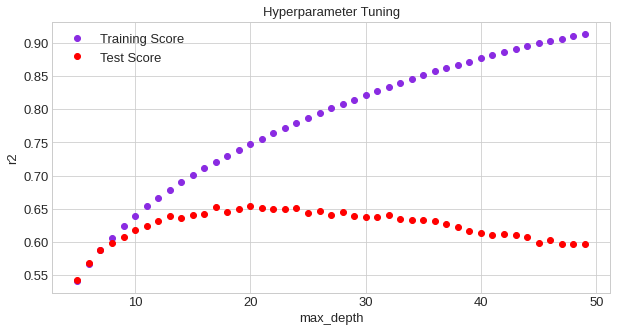

In [ ]:
model.plotHyperParamTuning('DTR', 'max_depth', list(range(5, 50, 1)), 'r2')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: DataConversionWarning: A column-vector y was passe

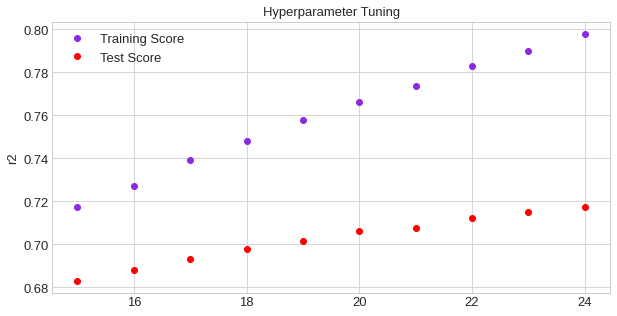

In [ ]:
# model.plotHyperParamTuning('RF', 'max_depth', list(range(25, 35, 1)), 'r2')

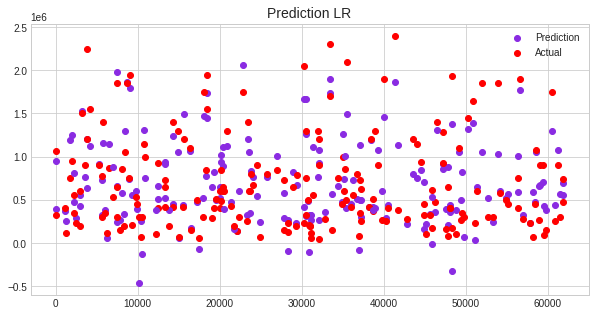

In [14]:
model.plotScatter('LR')

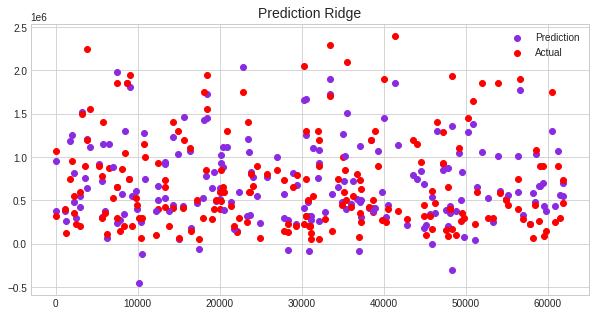

In [15]:
model.plotScatter('Ridge')

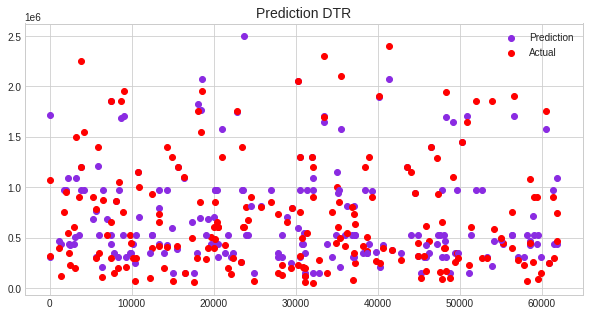

In [16]:
model.plotScatter('DTR')

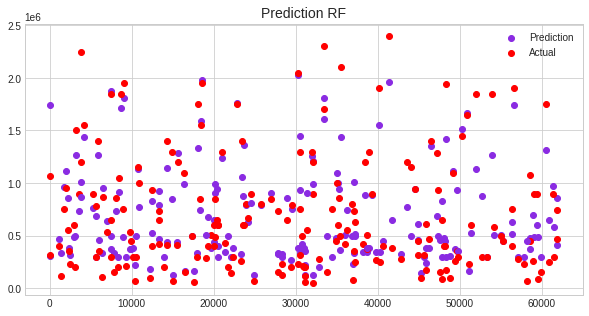

In [17]:
model.plotScatter('RF')

In [66]:
# without scaling
model = Model(df, 'price', 1000)
model.train()
model.predict()
model.evaluate()

,Model,RMSE,R2 Score,MAE
0,DTR,323036.450054,0.657428,220347.815742
1,LR,294940.901027,0.714426,212134.918461
2,Ridge,294735.466356,0.714824,211957.411444
3,RF,288036.646416,0.727640,197949.175687


In [67]:
model.predict(predictTrain = False, predictTest = False)

In [68]:
prediction = pd.DataFrame(model.predictionNoDatas['LR'], index=model.toPredict.index, columns=['Prediction'])
prediction.to_csv('prediction.csv')